<font size="6"><b>Project Demo</b></font>

<font size="5">CSCI 4850-5850 - Neural Networks</font>

<font size="4">Due: May 2 @ 9:30am</font>

<font size="6">Nutritional Data to Ingredient Mass Guesser - Bread Recipes</font>

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import csv

from src import *

from IPython.display import Image

#### Load Model & Load Normalizer Function

In [2]:
def load(folderpath, modelpath):
    
    recipe_max_path = f"{folderpath}/norm_recipe_max"
    recipe_min_path = f"{folderpath}/norm_recipe_min"
    
    quant_max_path = f"{folderpath}/norm_quant_max"
    quant_min_path = f"{folderpath}/norm_quant_min"
    
    model = keras.models.load_model(f'{folderpath}/{modelpath}.h5')
    
    recipe_normalizer = Normalizer()
    recipe_normalizer.load(recipe_max_path, recipe_min_path)
    
    quant_normalizer = Normalizer()
    quant_normalizer.load(quant_max_path, quant_min_path)
    

    
    return model, recipe_normalizer, quant_normalizer

<font size="5">All Parameters</font>

### Model to Load

In [3]:
# For Generator
rank = True

train_examples = 10000
test_examples = 100

# For Model
embed_dim = 1024 
stack = 6 
optimizer = keras.optimizers.Nadam() # Optimizer
loss = keras.losses.MSE # Regression Loss Function
metrics = keras.metrics.MeanSquaredError() # Metrics

# For Model Training
batch_size = 48
epochs = 1000
validation_split = 0.2
verbose = 0

2022-05-01 12:39:40.021880: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-05-01 12:39:40.058113: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-05-01 12:39:40.059149: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-05-01 12:39:40.060901: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

In [4]:
run = 1

In [5]:
model_name = f"{run}_rank_{rank}"
model_folder = f"./models/{model_name}"

<font size="5">General Explanation</font>

The goal of this network is to be able to pass in bread recipes with their nutritional information, things such as calories or sodium, and the network tell us the main ingredients of that recipe with their masses in grams. To accomplish this, we have provided our network with the accurate values relating those ingredients to the nutritional items. These values are shown below. They are all in grams for convenience and comparability.
![Nutrient.csv image](images/nutrients.png)

<font size="5">Generator</font>

We took the list above and ran it through a generator we built to create thousands of random recipes to use as training data. These recipes could then be ranked or normalized to alter how the network would interpret them.

In [6]:
generator = Generator('./data/nutrients.csv') # filename with data
generator.generate(train_examples) # generates arg number of examples

if rank:
    generator.rank()
    
recipes = generator.recipes
quant = generator.quant
    
#normalize
recipe_norm_example = Normalizer()
recipe_norm_example.fit(recipes)
recipes = recipe_norm_example.normalize(recipes)

quant_norm_example = Normalizer()
quant_norm_example.fit(quant)
quant = quant_norm_example.normalize(quant)
    
generator.recipes.shape

(10000, 28)

<font size="5">Model</font>

The model here uses stacked residual blocks to create a deep Network with skip connections.

In [7]:
embed_dim = embed_dim
stack = stack
i1 = keras.layers.Input(generator.recipes.shape[1:])
f1 = keras.layers.Flatten()(i1)
y1 = keras.layers.Dense(embed_dim)(f1)

# Stack residual blocks (skip connections)
for i in range(stack):
    y2 = y1
    y1 = keras.layers.Dense(embed_dim,
        activation=keras.activations.relu)(y1)
    y1 = keras.layers.Dropout(0.35)(y1)
    y1 = keras.layers.Add()([y1,y2])
    y1 = keras.layers.LayerNormalization()(y1)
    

o1 = keras.layers.Dense(quant.shape[1],activation=keras.activations.softplus)(y1)

    
model = keras.Model(i1,o1)

<font size="5">Model Training</font>

If you uncomment the fit function below and comment the model load function instead, you can run the model above in real time. You can also then see the plot of how the model trained if you run this live by uncommenting the plt section. However, this process could take quite a long time, as such, a pre-trained model has been prepared.

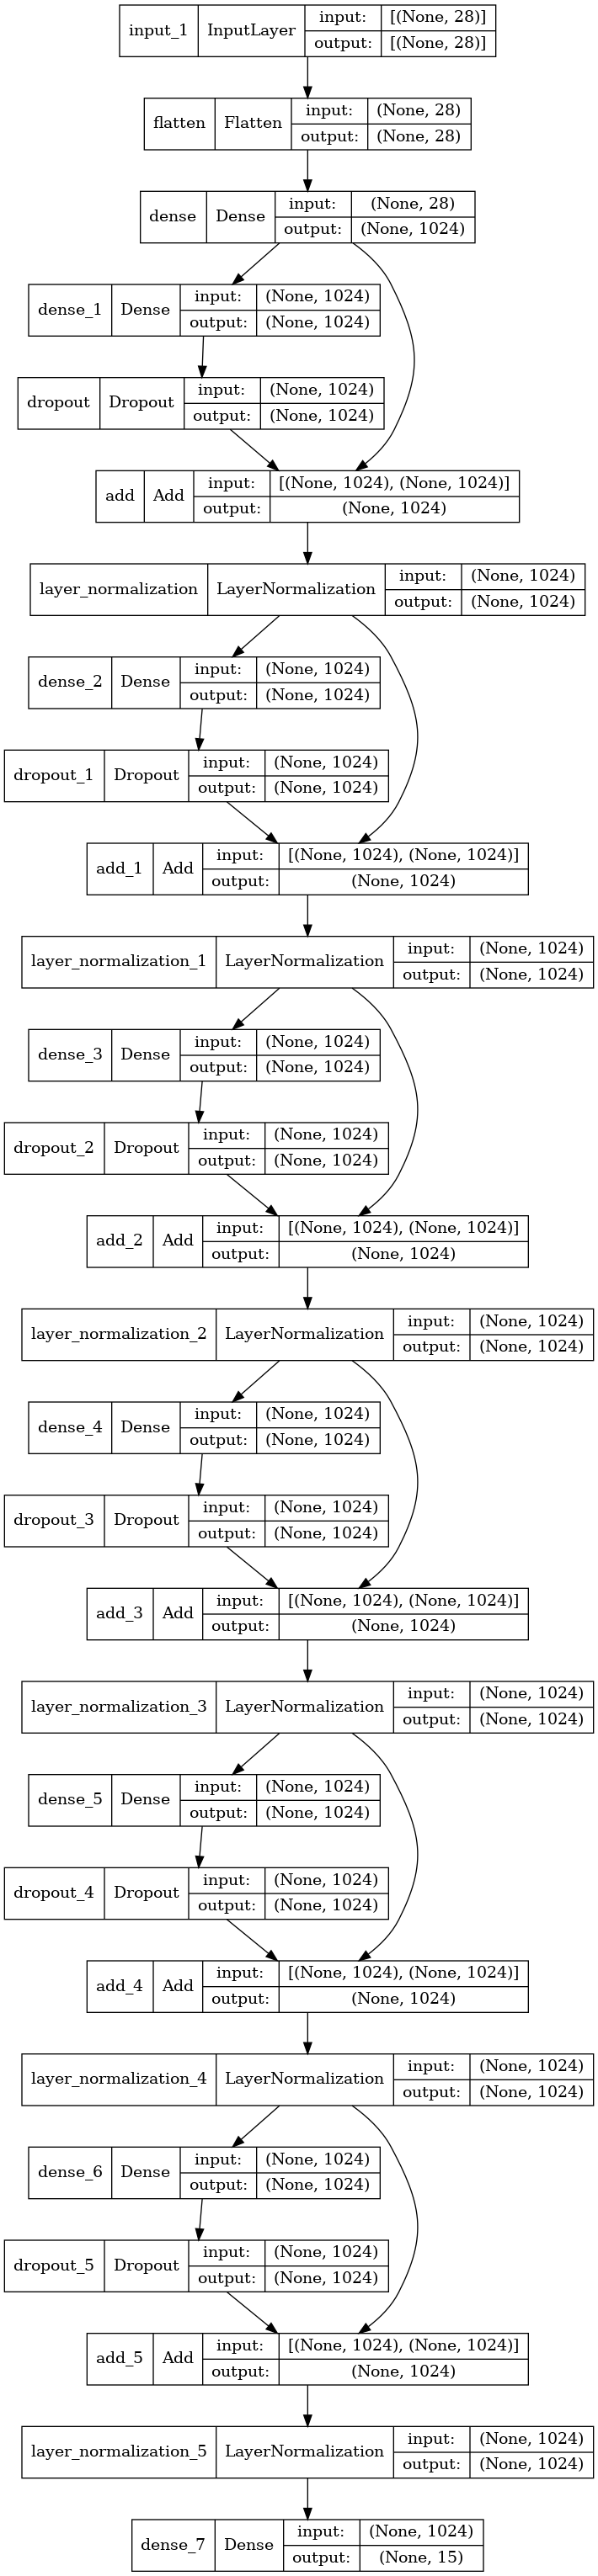

In [8]:
# history = model.fit(generator.recipes, generator.quant,batch_size=batch_size,epochs=epochs,
#                     validation_split = validation_split,verbose=verbose)

# plt.figure(1)
# # summarize history for accuracy
# plt.subplot(211)
# plt.plot(history.history['mean_squared_error'])
# plt.plot(history.history['val_mean_squared_error'])
# plt.plot(history.history['loss'])
# plt.ylabel('Progress')
# plt.xlabel('Epoch')
# plt.legend(['Training','Validation'],loc='upper right')



model, recipe_normalizer, quant_normalizer = load(model_folder, model_name)
keras.utils.plot_model(model,to_file='recipe_model.png',show_shapes=True,expand_nested=True)

<font size="5">Testing Fake Data</font>

In [9]:
#prediction values
test_gen = Generator('./data/nutrients.csv')
test_gen.generate(test_examples) # generates arg number of examples
if rank:
    test_gen.rank()
    
test_recipes = test_gen.recipes
test_quant = test_gen.quant
    
#normalize
test_recipes = recipe_normalizer.normalize(test_recipes)
test_quant = quant_normalizer.normalize(test_quant)


score = model.evaluate(test_recipes, test_quant, verbose=1)

2022-05-01 12:39:48.269025: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-05-01 12:39:48.442010: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301


4/4 [==============================] - 3s 7ms/step - loss: 0.0074 - mean_squared_error: 0.0074


In [10]:
pred = model.predict(test_recipes)
pred = quant_normalizer.inv_normalize(pred) #inverse normalize
    
actual = test_gen.quant

In [11]:
# Change this value to anything within the amount of 
# test_examples you specified in the parameter block above
testing_index = 0 
# Then rerun this block

ingredientsList =['Active Dry Yeast','Water','Salt','Bread Flour','Butter','Sugar','Egg','Dry Milk',
                  'Whole Wheat Flour','Vegetable Oil','Olive Oil','Honey','Brown Sugar','All-Purpose Flour','Milk']

print(f"Fake Recipe #{testing_index+1}\n")
for i in range(len(actual[0])):
    print(f"{ingredientsList[i].ljust(18)} - predicted: {str(round(pred[testing_index,i],3)).ljust(7)} grams | actual: {str(round(actual[testing_index,i],3)).ljust(6)} grams ")

Fake Recipe #1

Active Dry Yeast   - predicted: 91.359  grams | actual: 92.741 grams 
Water              - predicted: 602.826 grams | actual: 581.357 grams 
Salt               - predicted: 24.068  grams | actual: 24.065 grams 
Bread Flour        - predicted: 415.623 grams | actual: 415.354 grams 
Butter             - predicted: 0.002   grams | actual: 0.0    grams 
Sugar              - predicted: 0.021   grams | actual: 0.0    grams 
Egg                - predicted: 0.032   grams | actual: 0.0    grams 
Dry Milk           - predicted: 0.006   grams | actual: 0.0    grams 
Whole Wheat Flour  - predicted: 0.038   grams | actual: 0.0    grams 
Vegetable Oil      - predicted: 9.654   grams | actual: 10.103 grams 
Olive Oil          - predicted: 0.001   grams | actual: 0.0    grams 
Honey              - predicted: 0.0     grams | actual: 0.0    grams 
Brown Sugar        - predicted: 27.394  grams | actual: 29.708 grams 
All-Purpose Flour  - predicted: 0.286   grams | actual: 0.0    grams 
Mi

<font size="5">Testing Real Data</font>

In [12]:
data = list(csv.reader(open('./data/Recipe Data.csv')))
data = np.array(data)

In [13]:
recipe_quant = "./data/Recipe Data.csv"
ingr_nutr = "./data/nutrients.csv"

realdata = RealData(recipe_quant,ingr_nutr)
if rank:
    realdata.rank()


real_recipes = realdata.recipes
real_quant = realdata.quant

#normalize
real_recipes = recipe_normalizer.normalize(real_recipes)

In [14]:
pred = model.predict(real_recipes)
pred = quant_normalizer.inv_normalize(pred) #inverse normalize
    
actual = realdata.quant

For testing purposes, we have gathered a small list of recipes with the proper amounts of ingredients so we can accurately test our network.
![Nutrient.csv image](images/recipes.png)

In [15]:
# Change this value to an index of a recipe above
testing_index = 6
# Then rerun this block

ingredientsList = ['Active Dry Yeast','Water','Salt','Bread Flour','Butter','Sugar','Egg','Dry Milk',
                  'Whole Wheat Flour','Vegetable Oil','Olive Oil','Honey','Brown Sugar','All-Purpose Flour','Milk']
recipeNames = ['Traditional White Bread','Country White Bread','Sourdough Starter','French Countryside Bread',
               'Italian Herb Bread','White Bread','100% Whole Wheat Bread','Dough','Bagel dough',
               'Bread Pretzel','Butter Rolls','Pizza Crust']

print(f"Recipe - {recipeNames[testing_index]}\n")

#for testing_index in range(len(

for i in range(len(actual[0])):
    print(f"{ingredientsList[i].ljust(18)} - predicted: {str(round(pred[testing_index,i],3)).ljust(7)} grams | actual: {str(round(actual[testing_index,i],3)).ljust(6)} grams")

Recipe - 100% Whole Wheat Bread

Active Dry Yeast   - predicted: 7.063   grams | actual: 8.4    grams
Water              - predicted: 423.298 grams | actual: 383.5  grams
Salt               - predicted: 10.712  grams | actual: 11.4   grams
Bread Flour        - predicted: 0.161   grams | actual: 0.0    grams
Butter             - predicted: 0.005   grams | actual: 0.0    grams
Sugar              - predicted: 0.011   grams | actual: 0.0    grams
Egg                - predicted: 0.011   grams | actual: 0.0    grams
Dry Milk           - predicted: 0.0     grams | actual: 0.0    grams
Whole Wheat Flour  - predicted: 644.803 grams | actual: 630.0  grams
Vegetable Oil      - predicted: 0.0     grams | actual: 0.0    grams
Olive Oil          - predicted: 0.001   grams | actual: 0.0    grams
Honey              - predicted: 0.0     grams | actual: 0.0    grams
Brown Sugar        - predicted: 68.56   grams | actual: 66.7   grams
All-Purpose Flour  - predicted: 0.248   grams | actual: 0.0    grams
M